# 设置基本参数

In [8]:
import random
# power = [4.5,3.5,5]
# pr_worker_month = [4000,5000,4500]
# power = [4.5,3.5,5,4.5,3.5]
# pr_worker_month = [4000,5000,4500,4000,5000]
power = [4.5,3.5,5,4.5,3.5,5,4.5]
pr_worker_month = [4000,5000,4500,4000,5000,4500,4000]
pr = 100#单位产品的价格
pr_e = 1.5
T = 300*8*60*60
c_m = 30
c_f = 30000
E = 581#每度电排放581g二氧化碳

num_stations=7
num_works=150
# random.seed(1)
time_list = [round(random.random()*15,2) for _ in range(num_works)]
filename = './工序数据/优先关系'+str(num_works)+'.txt'

In [9]:
time_dict = dict(zip(list(range(1,num_works+1)),time_list))#注意这里要从1到num_works+1
def skill_time(level):
    return 1.5-0.1*level
def skill_salary(x):
    return 600*x+2000
def cacu_f1(sequence,skills):
    CT = sum(sequence)/num_stations#初始化CT
    #将其考虑为一个一维装箱问题，箱子的大小是不同的
    #将默认的箱子大小设置为无穷大，这样最多有四个箱子
    M = 10**5
    box = [M]*(num_stations+1)
    #然后用循环将前num_station个箱子的大小设置为CT/skill_time,即skill越高，box越大
    def set_box(CT):
        for i in range(num_stations):
            box[i] = CT/skill_time(skills[i])
    
    #切分函数
    def cut(CT):
        set_box(CT)
        stack = 0
        j = 0
        # ans = [[]*(num_stations+1)]
        #新建一个ans列表，列表中一共包含num_stations+1个空列表
        ans = [[] for _ in range(num_stations+1)]
        for i in range(num_works):
            if stack + time_dict[sequence[i]] <= box[j]:#如果第i个物品能放入第j个箱子，就放进去
                stack += time_dict[sequence[i]]
                ans[j].append(sequence[i])
            else:#如果放不下，就新开一个箱子,再放进去
                j += 1
                stack = 0
                stack += time_dict[sequence[i]]
                ans[j].append(sequence[i])
        return ans
    
    #循环计算rate值
    def cacu_rate(CT):
        while cut(CT)[num_stations]!=[]:
            CT += 0.01#这里步长先设置为1
        # print(CT)
        ans = cut(CT)
        return ans[:-1]
    res = cacu_rate(CT)
    
    station_time = [0]*num_stations#存储各个工作站的工作时间
    station_time_theory = [0]*num_stations
    for i in range(num_stations):
        for j in res[i]:
            station_time[i] += time_dict[j]*skill_time(skills[i])
            station_time_theory[i] += time_dict[j]

    CT_practice = max(station_time)
    #返回各任务分配情况，工作站实际工作时间，理论的CT, 实际的CT，工作站理论时间
    # return res,station_time,CT,CT_practice,station_time_theory
    return sum(station_time)/(num_stations*CT_practice),station_time,CT_practice

import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer

class Myproblem(ElementwiseProblem):
    def __init__(self,num_works,num_stations,**kwargs):
        self.xl = [0]*(num_stations+num_works)
        self.xu = [100]*(num_stations+num_works)
        self.num_works = num_works
        self.num_stations = num_stations
        chrom = [0]*(num_stations+num_works)
        sequence = chrom[:num_works]
        skills = chrom[num_works:]
        for i in range(0,num_works):
            sequence[i] = Integer(bounds=(1,num_works))
        for i in range(0,num_stations):
            skills[i] = Real(bounds=(0.0,10.0))
        super().__init__(vars=chrom, n_obj=3,xl=self.xl, xu=self.xu, **kwargs)
    
    def _evaluate(self, x, out, *args, **kwargs):

        sequence = x[:self.num_works]
        skills = x[self.num_works:]

        #每名员工的工资
        pr_worker_month = [skill_salary(i) for i in skills]

        rate,station_time,ct_practice = cacu_f1(sequence,skills)#station_time存储每个工作站的实际工作时间

        ct_practice = ct_practice/3600  # 时间单位换算成小时
        station_time = [i/3600 for i in station_time]

        electic = sum(a * b for a, b in zip(station_time, power))#总耗电量
        carbon = electic*E#碳排放
        fee_ele = electic*pr_e#电费
        fee_material = 10#材料费用
        fee_ele = electic*pr_e
        
        year_profit_total = (T/ct_practice)*(15-fee_ele-fee_material)-c_f-12*sum(pr_worker_month)

        out['F'] = np.array([-rate,carbon,-year_profit_total],dtype=float)
     
from pymoo.core.sampling import Sampling
import random

def gen_chrom(num_works):  # 生成一组基因序列
    # 生成优先矩阵
    def setPriority():
        # with open('./优先关系5.txt', 'r') as file:
        # with open('工序数据/优先关系50.txt', 'r') as file:
        with open(filename, 'r') as file:
            lines = file.readlines()

            # 将每行转换为元组并存储在列表中
        result = []
        for line in lines:
            list = line.strip().split(',')
            new_list = []
            for i in range(len(list)):
                new_list.append(int(list[i]))
            result.append(tuple(new_list))

        priority = np.zeros([num_works, num_works], dtype=int)
        for i in range(len(result)):
            priority[result[i][0] - 1, result[i][1] - 1] = 1

        return priority

    # 根据优先矩阵生成顺序列表（数据类型还需转化）
    def gen_sequence(p):
        element = []
        while p.any():
            row_sum = np.sum(p, axis=0)
            select = np.where(row_sum == 0)
            # element.append(select)
            for i in range(len(select)):
                element.append(select[i])
            for i in range(len(select)):
                p[select[i], :] = 0
                p[:, select[i]] = 0

        # 最后的终止节点必定为0，所以还要添上终止节点
        element.append(np.array([num_works - 1], dtype=int))
        return element

    # 对数据类型的转化
    def invert(b):
        new = []
        for i in range(len(b)):
            new.append([])
            for j in range(len(b[i])):
                new[i].append(b[i][j] + 1)
        return new

    # 去除子列表中的重复元素
    def duplicate(a):
        # 将[[1],[1,2],[1,2,3]]列表变为[[1],[2],[3]]这样的列表
        element_set = set()
        for i in range(len(a)):
            if i > 0:
                element_set = set(a[i - 1]) | element_set
                for j in range(len(a[i])):
                    if (a[i][j] in element_set):
                        a[i][j] = 0
        # 此时输出如[[1, 2], [0, 0, 3], [0, 0, 0, 4], [0, 0, 0, 0, 5, 6]]
        for i in range(len(a)):
            for j in range(len(a[i])):
                if 0 in a[i]:
                    a[i].remove(0)
        return a

    # 生成可行的工序顺序
    prio = setPriority()  # 优先矩阵
    b = gen_sequence(prio)  # 生成序列
    b = invert(b)  # 列表中的数组数据类型由ndarray转化为int
    prio_list = duplicate(b)  # 对序列中的元素去重
    for i in range(len(prio_list)):
        random.shuffle(prio_list[i])
    prio_list = sum(prio_list, [])
    sequence = np.array(prio_list)
    return sequence

class MySampling(Sampling):

    def _do(self,problemm,n_samples,**kwargs):
        # X = np.full((n_samples, problem.num_works+problem.num_stations), None, dtype=float)#要求返回的X必须是numpy.array格式,所以这里用np.full
        X = np.full((n_samples, num_works+num_stations), None, dtype=float)

        for i in range(n_samples):
            gen = gen_chrom(num_works=num_works)
            # for j in range(0,problem.num_works):
            for j in range(0,num_works):
                # X[i,j] = random.randint(1,problem.num_works)
                X[i,j] = gen[j]
            # for j in range(problem.num_works,problem.num_works+problem.num_stations):
            for j in range(num_works,num_works+num_stations):
                X[i,j] = round(random.random()*10,2)
        
        return X

from pymoo.core.crossover import Crossover

class MyCrossover(Crossover):
    def __init__(self):
        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):
        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape          #为什么这里的X是三维的？因为是从中选出两个个体，每个个体都是一个二维的np.array格式数据

        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, 0, dtype=float)

        # for each mating provided
        for k in range(n_matings):

            # get the first and the second parent
            a, b = X[0, k, :], X[1, k, :]

            # prepare the offsprings
            off_a = [0] * (problem.num_works+problem.num_stations)#offspring1
            off_b = [0] * (problem.num_works+problem.num_stations)#offspring2

            point_1 = random.randint(0,num_works-1)
            point_2 = random.randint(0,num_works-1)
            point_min = min(point_1,point_2)
            point_max = max(point_1,point_2)
            a_cross = a[point_min:point_max]
            b_corss = b[point_min:point_max]
            a_crossed = []
            b_crossed = []

            #遍历b中所有元素，若其在a_cross中，则将其加入a_crossed中
            for i in b:
                if i in a_cross:
                    a_crossed.append(i)
            
            for i in a:
                if i in b_corss:
                    b_crossed.append(i)

            #sequence crossover
            for i in range(problem.num_works+problem.num_stations):
                off_a[i] = a[i]
                off_b[i] = b[i]
            for i in range(point_min,point_max):
                off_a[i] = a_crossed[i-point_min]
                off_b[i] = b_crossed[i-point_min]

            point_m = random.randint(problem.num_works,problem.num_works+problem.num_stations-1)
            off_a[point_m] = b[point_m]
            off_b[point_m] = a[point_m]

            Y[0, k, :], Y[1, k, :] = off_a, off_b
        return Y

from pymoo.core.mutation import Mutation

class MyMutation(Mutation):
    def __init__(self):
        super().__init__()

    def _do(self, problem, X, **kwargs):

        for i in range(len(X)):

            r = np.random.random()
            if r < 0.05:
                sequence = gen_chrom(num_works=num_works)#前面部分的变异
                skills = [0] * num_stations
                for k in range(num_stations):
                    skills[k] = round(random.random()*10,2)
                chrom = np.concatenate([sequence, skills])
                for j in range(num_works+num_stations):
                    X[i,j] = chrom[j]

        return X

from pymoo.core.callback import Callback
#重写我的callback
class MyCallback(Callback):
    def __init__(self) -> None:
        super().__init__()
        self.data["best"] = []
        self.data["avg"] = []
        self.data["max"] = []

    def notify(self, algorithm):
        self.data["best"].append(algorithm.pop.get("F").min())
        self.data["avg"].append(algorithm.pop.get("F").mean())
        self.data["max"].append(algorithm.pop.get("F").max())

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      2 |             - |             -
     2 |      200 |      3 |  0.8378378378 |         nadir
     3 |      300 |      3 |  0.0002280453 |             f
     4 |      400 |      3 |  0.0014576912 |             f
     5 |      500 |      2 |  0.0061044912 |         ideal
     6 |      600 |      2 |  0.0009217153 |             f
     7 |      700 |      3 |  0.0010162013 |             f
     8 |      800 |      2 |  0.0032854789 |         nadir
     9 |      900 |      2 |  0.0003379535 |             f
    10 |     1000 |      4 |  0.0006461589 |             f
    11 |     1100 |      5 |  0.0007267201 |             f
    12 |     1200 |      2 |  0.0016742395 |             f
    13 |     1300 |      2 |  0.0017181953 |             f
    14 |     1400 |      3 |  0.0019160480 |             f
    15 |     1500 |      3 |  0.0028793771 |         nadir
    16 |     1600 |      8 |  0.0001006679 |            

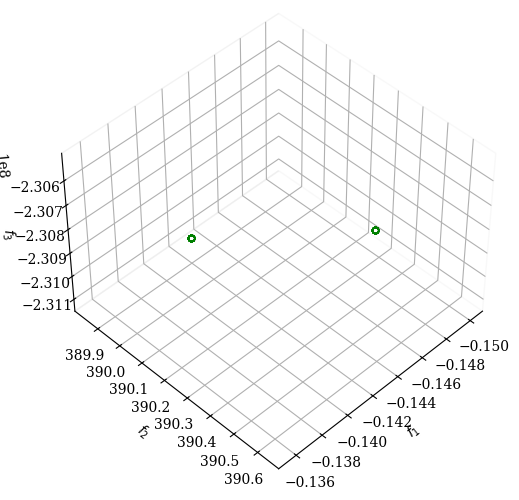

In [10]:
from pymoo.optimize import minimize
from matplotlib import pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination

termination = get_termination("time", "00:00:30")
m = Myproblem(num_works=num_works,num_stations=num_stations)
algorithm = NSGA2(
    pop_size=100,
    sampling=MySampling(),
    crossover=MyCrossover(),
    mutation=MyMutation(),
)
res = minimize(
    m,
    algorithm,
    termination=termination,
    verbose=True,
    callback = MyCallback(),
    )
print("Function value: %s" % res.F[0])
print("最优解:", res.X)
plot = Scatter()
plot.add(res.F, facecolor="none", edgecolor="green")
plot.show()

from pymoo.indicators.hv import HV
from pymoo.indicators.spacing import SpacingIndicator
A = res.F
for i in range(A.shape[1]):
    A[:, i] = A[:, i] / np.max(A[:, i])
# print(A)
ref_point = np.max(A, axis=0)
ind = HV(ref_point=ref_point)
print("HV", ind(A))
spacing = SpacingIndicator()
spacing = spacing._do(A)
print('spacing',spacing)
ans = {}
ans['NSGA2的HV'] = ind(A)
ans['NSGA2的spacing'] = spacing

# 上面是NSGA-II结果

c:\Users\27249\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      2 |             - |             -
     2 |      200 |      1 |  2.147240E+07 |         nadir
     3 |      300 |      2 |  1.0000000000 |         ideal
     4 |      400 |      1 |  2.142805E+07 |         nadir
     5 |      500 |      2 |  1.0000000000 |         ideal
     6 |      600 |      2 |  0.1002691790 |         ideal
     7 |      700 |      2 |  1.0440165062 |         nadir
     8 |      800 |      2 |  0.000000E+00 |             f
     9 |      900 |      2 |  0.1396449704 |         ideal
    10 |     1000 |      2 |  0.3214695752 |         ideal
    11 |     1100 |      2 |  0.3738170347 |         nadir
    12 |     1200 |      1 |  1.144800E+04 |         ideal
    13 |     1300 |      2 |  1.0000000000 |         ideal
    14 |     1400 |      2 |  0.3361702128 |         ideal
    15 |     1500 |      2 |  1.9746835443 |         nadir
    16 |     1600 |      2 |  0.4513888889 |         ide

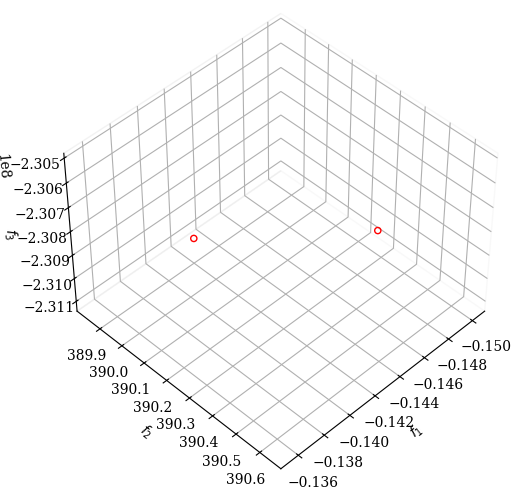

In [11]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)
problem = Myproblem(num_works=num_works,num_stations=num_stations)
# create the algorithm object
algorithm = NSGA3(pop_size=100,
                  sampling=MySampling(),
                  crossover=MyCrossover(),
                  mutation=MyMutation(),
                  ref_dirs=ref_dirs)
# execute the optimization
res = minimize(problem=problem,
               algorithm=algorithm,
               seed=1,
               termination=termination,
               verbose=True)
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

from pymoo.indicators.hv import HV
from pymoo.indicators.spacing import SpacingIndicator
A = res.F
for i in range(A.shape[1]):
    A[:, i] = A[:, i] / np.max(A[:, i])
# print(A)
ref_point = np.max(A, axis=0)
ind = HV(ref_point=ref_point)
print("HV", ind(A))
spacing = SpacingIndicator()
spacing = spacing._do(A)
print('spacing',spacing)
ans['NSGA3的HV'] = ind(A)
ans['NSGA3的spacing'] = spacing

# 上面是NSGA-III结果

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      2 |             - |             -
     2 |      182 |      2 |  2.743333E+14 |         nadir
     3 |      273 |      2 |  1.4221388368 |         nadir
     4 |      364 |      2 |  0.1723602484 |         ideal
     5 |      455 |      2 |  1.063333E+02 |         nadir
     6 |      546 |      2 |  1.0000000000 |         ideal
     7 |      637 |      2 |  0.9166666667 |         nadir
     8 |      728 |      3 |  0.2765957447 |         nadir
     9 |      819 |      2 |  2.3000000000 |         ideal
    10 |      910 |      2 |  0.7932816537 |         ideal
    11 |     1001 |      3 |  0.2275449102 |         ideal
    12 |     1092 |      3 |  1.0000000000 |         ideal
    13 |     1183 |      9 |  0.2255639098 |         nadir
    14 |     1274 |     19 |  0.0472440945 |         nadir
    15 |     1365 |     44 |  0.000000E+00 |             f
    16 |     1456 |      2 |  0.9999999998 |         ide

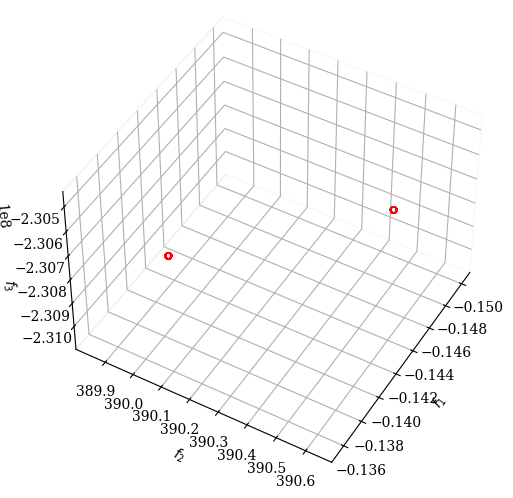

In [12]:
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = Myproblem(num_works=num_works,num_stations=num_stations)
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# create the algorithm object
algorithm = CTAEA(ref_dirs=ref_dirs,
                  sampling=MySampling(),
                  crossover=MyCrossover(),
                  mutation=MyMutation(),
                  callback=MyCallback())

# execute the optimization
res = minimize(problem,
               algorithm,
               termination=termination,
               seed=1,
               verbose=True,
               )

sc = Scatter(legend=False, angle=(45, 30))
sc.add(problem.pareto_front(ref_dirs), plot_type='surface', alpha=0.2, label="PF", color="blue")
sc.add(res.F, facecolor="none", edgecolor="red")
sc.show()

# 上面是CTAEA结果

In [13]:
from pymoo.indicators.hv import HV
from pymoo.indicators.spacing import SpacingIndicator
A = res.F
for i in range(A.shape[1]):
    A[:, i] = A[:, i] / np.max(A[:, i])
# print(A)
ref_point = np.max(A, axis=0)
ind = HV(ref_point=ref_point)
print("HV", ind(A))
spacing = SpacingIndicator()
spacing = spacing._do(A)
print('spacing',spacing)
ans['CTAEA的HV'] = ind(A)
ans['CTAEA的spacing'] = spacing

HV 0.0
spacing 0.0


Function value: [-1.42857143e-01  3.89851000e+02 -2.31120865e+08]
最优解: [[1.   2.   5.   ... 0.25 0.   0.57]
 [1.   2.   5.   ... 0.25 0.   0.57]
 [1.   2.   5.   ... 0.34 0.04 0.57]
 ...
 [1.   2.   5.   ... 0.25 0.   0.57]
 [1.   2.   5.   ... 0.25 0.   0.57]
 [1.   2.   5.   ... 0.25 0.   0.57]]


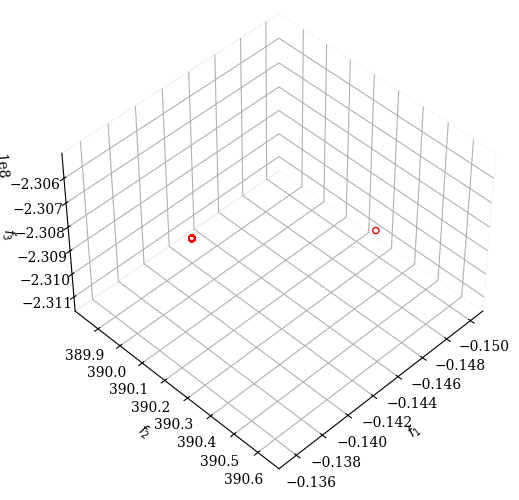

In [14]:
from pymoo.core.callback import Callback

# 定义自定义邻域搜索操作
class MyNeighborhoodSearch:

    def __init__(self):
        pass

    def search(self, problem, x):
        # 执行邻域搜索操作，例如将x替换为一定范围内的随机数
        # x_new = np.random.uniform(low=x-0.1, high=x+0.1)
        x_new = np.random.uniform(low=max(x-0.1,0),high=min(x+0.1,10))

        return round(x_new,2)

#重写我的callback
class MyCallback(Callback):
    def __init__(self,search) -> None:
        super().__init__()
        self.search = search
        self.best_individual = None

    def notify(self, algorithm):
        pop = algorithm.pop

        # 第一代，随机选择一个个体作为初始最优个体
        if self.best_individual is None:
            self.best_individual = pop[0].X

        # 找到当前代的最优个体
        best_index = np.argmin(pop.get("F")[:, 0])  # 这里以第一个目标函数为例
        best_individual = pop[best_index].X

        # 如果最优个体发生变化，则进行邻域搜索操作
        if not np.array_equal(self.best_individual, best_individual):
            self.best_individual = best_individual
            problem = algorithm.problem

            # for j in range(problem.n_var):
            for j in range(problem.num_works,problem.num_stations+problem.num_works-1):
                x_new = self.search.search(problem, best_individual[j])
                best_individual[j] = x_new

            # 更新当前最优个体
            pop[best_index].X = best_individual

# %%
# from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from matplotlib import pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2

# m = Myproblem(num_works=5,num_stations=3)
m = Myproblem(num_works=num_works,num_stations=num_stations)

algorithm = NSGA2(
    pop_size=100,
    sampling=MySampling(),
    crossover=MyCrossover(),
    mutation=MyMutation(),
    eliminate_duplicates = True,
)

search = MyNeighborhoodSearch()

res = minimize(
    m,
    algorithm,
    termination=termination,
    seed=1,
    # verbose=True,
    verbose=False,
    # save_history=True,
    callback = MyCallback(search),
    )
print("Function value: %s" % res.F[0])
print("最优解:", res.X)
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [15]:
from pymoo.indicators.hv import HV
from pymoo.indicators.spacing import SpacingIndicator
A = res.F
for i in range(A.shape[1]):
    A[:, i] = A[:, i] / np.max(A[:, i])
# print(A)
ref_point = np.max(A, axis=0)
ind = HV(ref_point=ref_point)
print("HV", ind(A))

spacing = SpacingIndicator()
spacing = spacing._do(A)
print('spacing',spacing)
ans['NSGA2-LS的HV'] = ind(A)
ans['NSGA2-LS的spacing'] = spacing

HV 0.0
spacing 0.00044820722569093984


# 上面是NSGA-II-LS结果

# 加入邻域搜索的NSGA-III

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      2 |             - |             -
     2 |      200 |      1 |  9.596183E+07 |         nadir
     3 |      300 |      1 |  0.000000E+00 |             f
     4 |      400 |      2 |  1.0000000000 |         ideal
     5 |      500 |      1 |  1.504800E+04 |         ideal
     6 |      600 |      2 |  1.0000000000 |         ideal
     7 |      700 |      2 |  0.0005593778 |             f
     8 |      800 |      2 |  0.0007434198 |             f
     9 |      900 |      2 |  0.0007434198 |             f
    10 |     1000 |      2 |  0.0044515472 |         ideal
    11 |     1100 |      2 |  0.0003948589 |             f
    12 |     1200 |      1 |  1.332000E+04 |         ideal
    13 |     1300 |      1 |  2.050724E+06 |         ideal
    14 |     1400 |      1 |  0.000000E+00 |             f
    15 |     1500 |      2 |  1.0000000000 |         ideal
    16 |     1600 |      2 |  0.000000E+00 |            

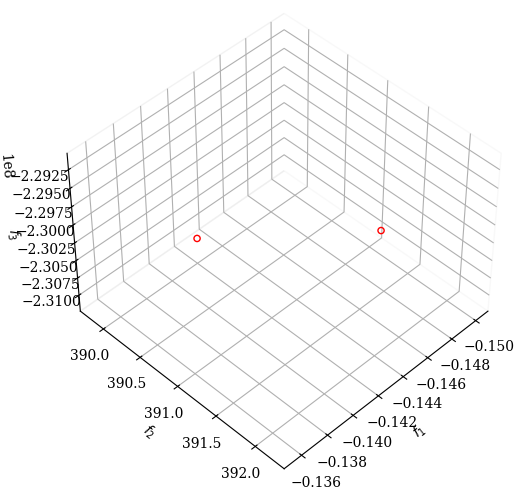

In [16]:
from pymoo.core.callback import Callback

# 定义自定义邻域搜索操作
class MyNeighborhoodSearch:

    def __init__(self):
        pass

    def search(self, problem, x):
        # 执行邻域搜索操作，例如将x替换为一定范围内的随机数
        # x_new = np.random.uniform(low=x-0.1, high=x+0.1)
        x_new = np.random.uniform(low=max(x-0.1,0),high=min(x+0.1,10))

        return round(x_new,2)

#重写我的callback
class MyCallback(Callback):
    def __init__(self,search) -> None:
        super().__init__()
        self.search = search
        self.best_individual = None

    def notify(self, algorithm):
        pop = algorithm.pop

        # 第一代，随机选择一个个体作为初始最优个体
        if self.best_individual is None:
            self.best_individual = pop[0].X

        # 找到当前代的最优个体
        best_index = np.argmin(pop.get("F")[:, 0])  # 这里以第一个目标函数为例
        best_individual = pop[best_index].X

        # 如果最优个体发生变化，则进行邻域搜索操作
        if not np.array_equal(self.best_individual, best_individual):
            self.best_individual = best_individual
            problem = algorithm.problem

            # for j in range(problem.n_var):
            for j in range(problem.num_works,problem.num_stations+problem.num_works-1):
                x_new = self.search.search(problem, best_individual[j])
                best_individual[j] = x_new

            # 更新当前最优个体
            pop[best_index].X = best_individual

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)
problem = Myproblem(num_works=num_works,num_stations=num_stations)
# create the algorithm object
algorithm = NSGA3(pop_size=100,
                  sampling=MySampling(),
                  crossover=MyCrossover(),
                  mutation=MyMutation(),
                  ref_dirs=ref_dirs)
# execute the optimization

search = MyNeighborhoodSearch()

res = minimize(problem=problem,
               algorithm=algorithm,
            #    seed=1,
               termination=termination,
               verbose=True,
               callback = MyCallback(search),
               )
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

from pymoo.indicators.hv import HV
from pymoo.indicators.spacing import SpacingIndicator
A = res.F
for i in range(A.shape[1]):
    A[:, i] = A[:, i] / np.max(A[:, i])
# print(A)
ref_point = np.max(A, axis=0)
ind = HV(ref_point=ref_point)
print("HV", ind(A))
spacing = SpacingIndicator()
spacing = spacing._do(A)
print('spacing',spacing)
ans['NSGA3-LS的HV'] = ind(A)
ans['NSGA3-LS的spacing'] = spacing

In [17]:
ans = {key: round(value, 3) for key, value in ans.items()}
ans

{'NSGA2的HV': 0.0,
 'NSGA2的spacing': 0.0,
 'NSGA3的HV': 0.0,
 'NSGA3的spacing': 0.0,
 'CTAEA的HV': 0.0,
 'CTAEA的spacing': 0.0,
 'NSGA2-LS的HV': 0.0,
 'NSGA2-LS的spacing': 0.0,
 'NSGA3-LS的HV': 0.0,
 'NSGA3-LS的spacing': 0.0}

In [18]:
import pandas as pd
dfans = pd.DataFrame([ans])
dfans.to_csv('本次运行的结果.csv')